# 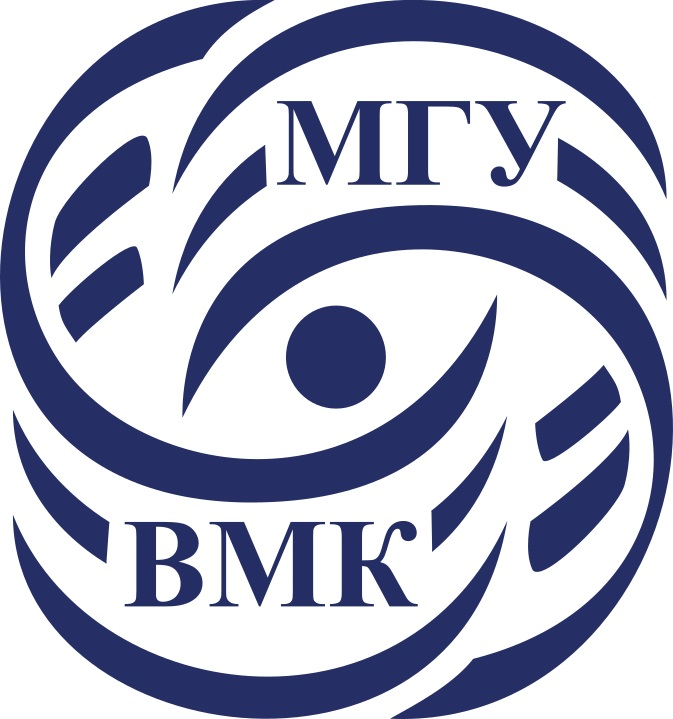

# Машинное обучение. ВМК МГУ

## Практическое задание 4: Линейные модели, часть 1: Регрессия

### Важно! О формате сдачи

* Все задания в этой части оцениваются по системе <font color='red'>кросс-рецензирования.</font>
* При решении ноутбука <font color='red'>используйте данный шаблон.</font> Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно
* Везде, где в формулировке задания есть <font color='red'>какой-либо вопрос (или просьба вывода)</font>, необходимо прописать ответ в ячейку (код или markdown).
* Наличие <font color='red'>кода решения обязательно.</font> Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.
* Если в ячейке написана фраза <font color='red'>"Вывод"/"Ответ на вопрос" итд</font>, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано <font color='red'>"Your code here" и пр. </font>, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст

Цель данного задания:

* Узнать, что такое переобучение и как с ним бороться в линейных моделях;
* Понять, чем отличаются разные регуляризаторы;
* Научиться решать задачу регрессии линейными моделями.
-------
При выполнении данного задания необходимо последовательно запустить все ячейки ноутбука и ответить на $11$ вопросов. Ответы на вопросы будут проверены в рамках кросс-ревью. Всего за ответы на вопросы можно получить $20$ баллов.

### <font color=orange>*Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: 30 минут </font>*

## Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
# Устанавливаем урезанную версию requeirements.txt для ускорения установки
# Если будут всплывать ошибки о несовместимости библиотек, то ничего страшного
# На это задание они не влияют

! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
! pip install -r /content/requirements_small.txt

In [1]:
import catboost
assert(catboost.__version__ == '1.2.2')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

## Часть 1. Линейная регрессия

Напомним, что линейная регрессия — это модель следующего вида: $$a(x) = \langle w, x \rangle + b$$ где $w \in \mathbb{R}^d$, $b \in \mathbb{R}$. Обучить линейную регрессию — значит найти $w$ и $b$.

Для обучения линейной регрессии, равно как и для обучения остальных простых моделей (линейные модели, решающие деревья, knn и т.д.) отлично подходит библиотека scikit-learn (sklearn): в ней очень понятный и простой интерфейс.

Однако для обучения более сложных моделей вроде бустинга и нейронных сетей всё же нужно пользоваться специализированными библиотеками: XGBoost, LightGBM, CatBoost и пр. для градиентного бустинга над деревьями, PyTorch, Tensorflow и пр. для нейронных сетей.

Так как мы будем обучать линейную регрессию, нам подойдет реализация из sklearn. В sklearn есть несколько классов, реализующих линейную регрессию. Основные это:

- Ridge — линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
- Lasso — линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

Также есть SVR, ElasticNet  и пр., но не будем сегодня о них

У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

Рассмотрим, модельные данные для задачи регрессии. Пусть $x$ будет обычным числом из равномерного распределения, а $y = 0.5 \cdot x + 0.1$ &mdash; целевая переменная. При этом наблюдаем мы $\overline{y} = y + \varepsilon,~\varepsilon \sim \mathcal{N}(0, 0.01)$.

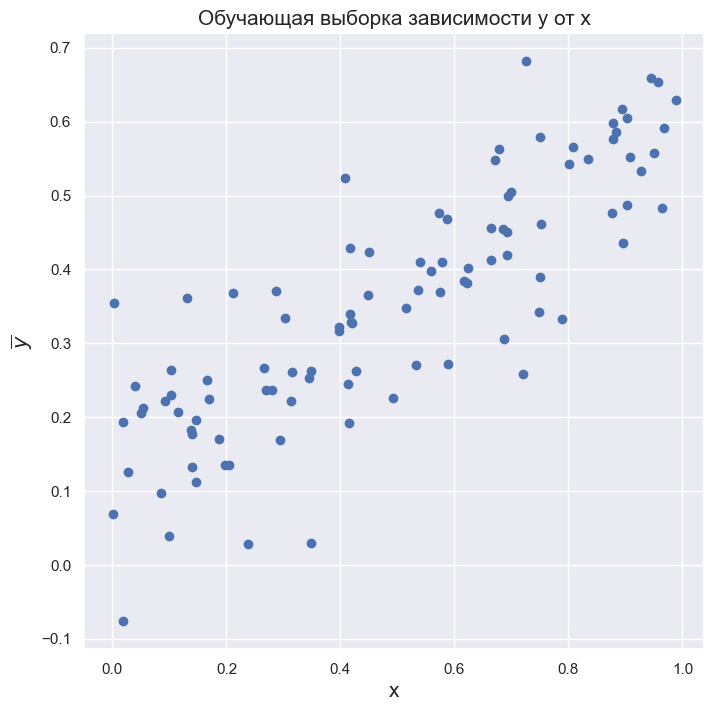

In [3]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = X * 0.5 + 0.1 + np.random.randn(100) * 0.1

plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.title("Обучающая выборка зависимости y от x", size=15)
plt.xlabel("x", size=15)
plt.ylabel(r'$\overline{y}$', size=15)
plt.show()

Обучим линейную регрессию, и посмотрим как регуляризация влияет на качество модели. В реализации библиотеки sklearn коэффициент регуляризации задаётся параметром alpha

In [4]:
from sklearn.linear_model import Ridge

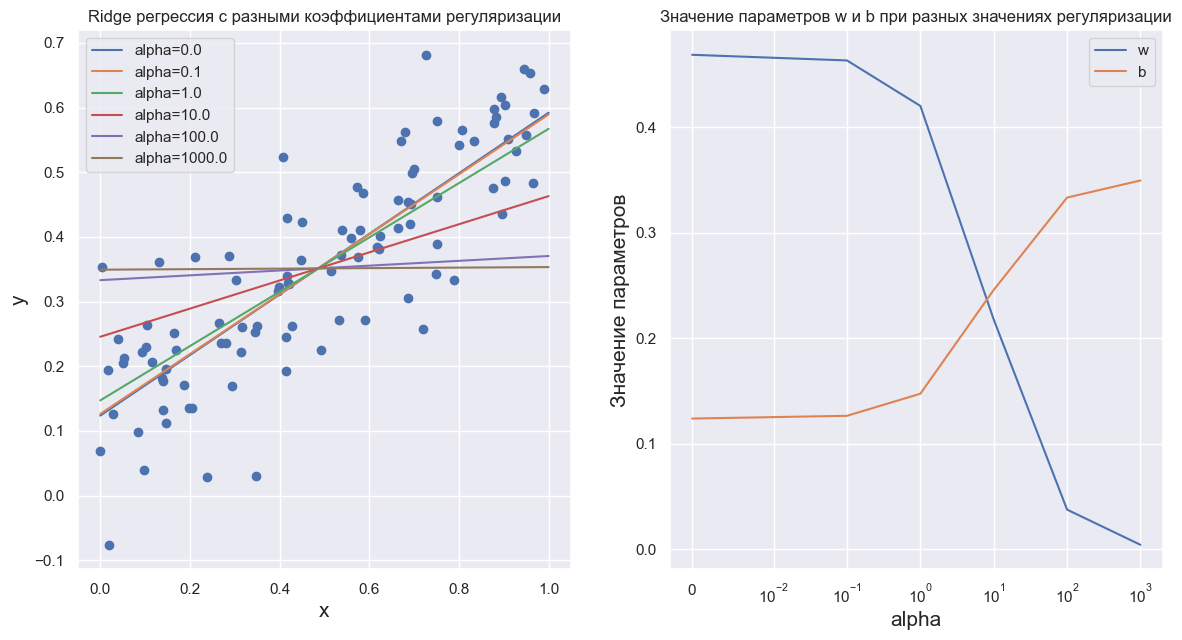

In [5]:
x_axis = np.linspace(0, 1, 200)
fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].scatter(X, Y)

w = []
b = []

alphas = [0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X[:, None], Y)
    pred = reg.predict(x_axis[:, None])
    w.append(reg.coef_[0])
    b.append(reg.intercept_)
    axs[0].plot(x_axis, pred, label="alpha=" + str(alpha))

axs[0].legend()
axs[0].set_xlabel("x", size=15)
axs[0].set_ylabel("y", size=15)
axs[0].set_title("Ridge регрессия с разными коэффициентами регуляризации")
axs[1].plot(alphas, w, label="w")
axs[1].plot(alphas, b, label="b")
axs[1].set_xlabel("alpha", size=15)
axs[1].set_ylabel("Значение параметров", size=15)
axs[1].set_title("Значение параметров w и b при разных значениях регуляризации")
axs[1].set_xscale("symlog", linthresh=0.01)
axs[1].legend()
plt.show()

### **Вопрос 1** (1 балл)

Как зависят параметры модели от константы регуляризации? А качество?



При увеличении константы регуляризации веса модели будут стремиться к меньшим значениям. Когда константа очень велика, большая часть весов может стать нулевой при L1-регуляризации или очень близкой к нулю при L2-регуляризации.

С ростом константы регуляризации увеличивается риск недообучения - модель становится слишком простой. При меньших значениях константы увеличивается риск переобучения, модель слишком подстраивается под обучающие данные, включая шум.

### **Вопрос 2** (1 балл)

Почему при обучении линейных моделей, коэффициент $b$ не регуляризуется? Дайте ответ с опорой на лекции и увиденные картинки.

Свободный член $b$ не связан с каким-либо признаком и не отражает важность или вес признака. Он просто корректирует предсказание на определенное смещение.

Регуляризация, в основном, предназначена для уменьшения влияния отдельных признаков на ответ, чтобы предотвратить переобучение. Смещение $b$ не масштабирует признак, а просто смещает ответ.

Если бы $b$ подвергался регуляризации, это могло бы привести к неестественному смещению предсказаний, особенно если регуляризационный штраф был бы велик. Таким образом, прогнозы могут стать систематически смещенными, что не всегда желательно.

------

Казалось бы, зачем нам эта глупая регуляризация?!

Давайте рассмотрим ещё один модельный пример. Представим, что кто-то добавил в данные к переменной $x$ её же умноженную на $2$. То есть, теперь у нас два признака $x_1$ и $x_2 = 2 \cdot x_1$. Тогда, $y = c \cdot 0.5 \cdot x_1 + \frac{1 - c}{4} \cdot x_2 + 0.1$, где $c$ любое сколь угодно большое вещественное число. Это может привести к тому, что без регуляризации мы рискуем выучить очень большие веса!

In [6]:
np.random.seed(1)
X2 = np.hstack((X[:, None], 2 * X[:, None]))
Y2 = X2[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X2, Y2)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 0.1006220738265918 	w2: 0.20124414765318363


Коэффициенты адекватные, хотя и не похожи на изначальную зависимость. Но что, если $x_2$ будет равняться $3 \cdot x_1$?

In [7]:
np.random.seed(1)
X3 = np.hstack((X[:, None], 3 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 20443435586638.344 	w2: -6814478528879.279


Тут вот уже не повезло. Коэффициенты случайно выучились неадекватно большими. Создадим обучающую выборку из того же распределения и посмотрим на качество

In [8]:
np.random.seed(2)
X3_test = np.random.uniform(0, 1, 100)
X3_test = np.hstack((X3_test[:, None], 3 * X3_test[:, None]))
Y3_test = X3_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

Y3_test_pred = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss: %.4f" % np.mean((Y3_test_pred - Y3_test) ** 2))

MSE loss: 0.0208


Вроде бы неплохое, но что если мы добавим ко второму признаку одного из объектов небольшой шум?

In [9]:
X3_test[0, 1] = X3_test[0, 1] + 1e-10
Y3_test_pred_noisy = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss:", np.mean((Y3_test_pred_noisy - Y3_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y3_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y3_test_pred[0])

MSE loss: 4641.705785775192
Предсказание для первого объекта с шумом:  -681.02734375
Предсказание для первого объекта без шума:  0.419921875


Как видим, даже небольшое изменение в данных, приводит к резкому падению качества.

### **Вопрос 3** (2 балла)
Рассмотрите больше примеров с двумя признаками $x_1$ и $x_2$, где $x_2$ линейно зависит от $x_1$. Убедитесь, что линейная модель без регуляризации крайне неустойчива.

In [10]:
# x2 = 5 * x1
np.random.seed(1)
X4 = np.hstack((X[:, None], 5 * X[:, None]))
Y4 = X4[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X4, Y4)
print("Weights for x2 = 5 * x1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

# x2 = -3 * x1
np.random.seed(1)
X5 = np.hstack((X[:, None], -3 * X[:, None]))
Y5 = X5[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X5, Y5)
print("Weights for x2 = -3 * x1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

Weights for x2 = 5 * x1
w1: 14779777306790.635 	w2: -2955955461358.026
Weights for x2 = -3 * x1
w1: 20443435586638.344 	w2: 6814478528879.279


Как видим, получаются неадекватно большие/маленькие веса, что показывает неустойчивость модели в случае, когда один признак линейно зависим от другого

-----

Теперь добавим регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

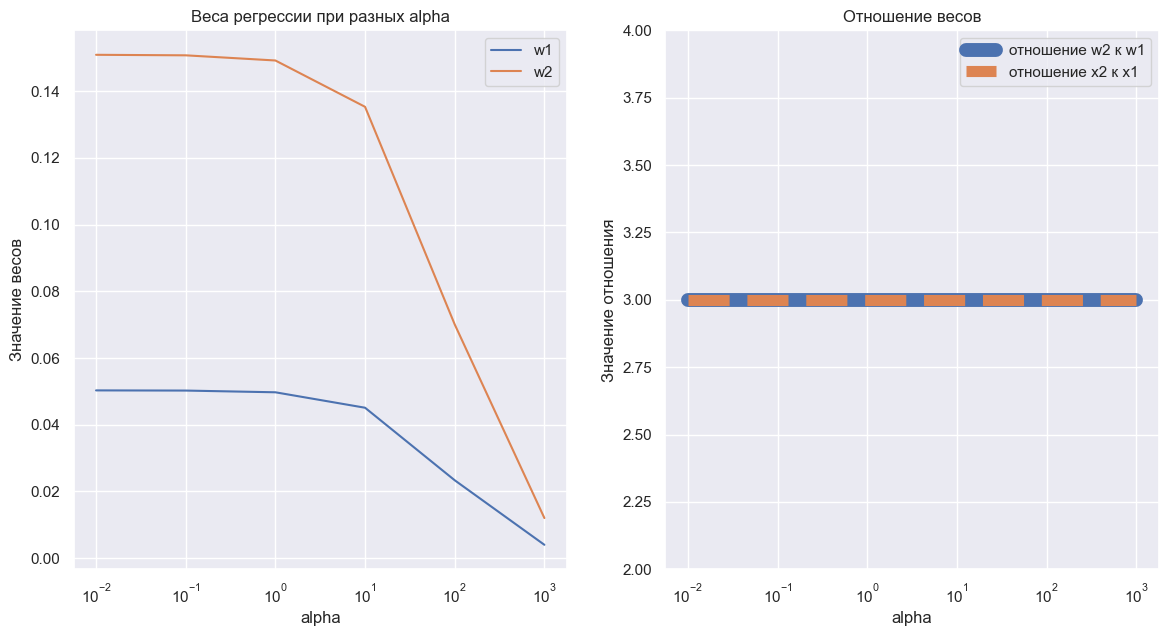

In [11]:
w1 = []
w2 = []

alphas = [0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X3, Y3)
    w1.append(reg.coef_[0])
    w2.append(reg.coef_[1])

w1 = np.array(w1)
w2 = np.array(w2)

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].plot(alphas, w1, label="w1")
axs[0].plot(alphas, w2, label="w2")
axs[0].set_xscale("log")
axs[0].set_title("Веса регрессии при разных alpha")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("Значение весов")
axs[0].legend()
axs[1].plot(alphas, w2 / w1, label="отношение w2 к w1", linewidth=10)
axs[1].plot([0.01, 1000], [3, 3], label="отношение x2 к x1", linestyle="--", linewidth=8)
axs[1].set_xscale("log")
axs[1].set_ylim(2,4)
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Значение отношения")
axs[1].set_title("Отношение весов")
axs[1].legend()
plt.show()

### **Вопрос 4** (2 балла)

Как думаете, почему отношение между весами постоянно? (подсказка, необходимо выписать функцию потерь и посчитать производные по весам)

Функция потерь для Ridge регрессии включает в себя как ошибку прогноза, так и штраф за большие веса:

$J(w) = \sum_{i=1}^{n} (y_i - (w_1 x_{1i} + w_2 x_{2i}))^2 + \alpha (w_1^2 + w_2^2)$

где:
- $w_1, w_2$ - веса модели,
- $x_{1i}, x_{2i}$ - признаки модели для i-го наблюдения,
- $y_i$ - истинные значения целевой переменной для i-го наблюдения,
- $\alpha$ - параметр регуляризации.

Посчитаем частные производные функции потерь по каждому весу и приравняем к нулю:

$\frac{\partial J}{\partial w_1} = -2 \sum_{i=1}^{n} x_{1i} (y_i - (w_1 x_{1i} + w_2 x_{2i})) + 2 \alpha w_1 = 0$

$\frac{\partial J}{\partial w_2} = -2 \sum_{i=1}^{n} x_{2i} (y_i - (w_1 x_{1i} + w_2 x_{2i})) + 2 \alpha w_2 = 0$

Вернёмся к данным. Так как у нас $x2 = 3 * x1$, то есть прямая зависимость между $x1$ и $x2$. В нашем случае $x_{2i} = 3 x_{1i}$, а это значит, что уравнения принимают следующий вид:

$\frac{\partial J}{\partial w_1} = -2 \sum_{i=1}^{n} x_{1i} (y_i - (w_1 x_{1i} + 3 w_2 x_{1i})) + 2 \alpha w_1 = 0$

$\frac{\partial J}{\partial w_2} = -2 \sum_{i=1}^{n} 3 x_{1i} (y_i - (w_1 x_{1i} + 3 w_2 x_{1i})) + 2 \alpha w_2 = 0$

Если умножить первое уравнение на 3 и вычесть из него второе, мы получим, что члены, содержащие $y_i$, сокращаются, и останутся только члены, содержащие веса и признаки. Так как признаки связаны линейной зависимостью, отношение $w_2/w_1$ будет определяться этой линейной зависимостью независимо от значения $\alpha$, что и видно на правом графике. Следовательно, отношение весов стремится к отношению коэффициентов при признаках, то есть к 3, что соответствует коэффициенту пропорциональности между $x2$ и $x1$. Это объясняет, почему отношение между весами остаётся постоянным при изменении $\alpha$.

-----
<font color="white" style="opacity:0.2023"></font>

Заметим, что при $l_2$ регуляризации в данном примере веса получились пропорциональны значениям признаков. При этом, мы знаем, что оба признака взаимно однозначны, и прогноз можно делать только по одному из них. Для этого придумана $l_1$ регуляризация. В билиотеке sklearn линейная регрессия с $l_1$ регуляризацией реализована в классе Lasso

### **Вопрос 5** (2 балла)

Почему в нашем примере $l_1$ регуляризация приведёт к разреживанию весов? (подсказка, нужно опять подсчитать производную, но обратите внимание на дифференцируемость модуля).

L1-регуляризация добавляет к функции потерь штраф, пропорциональный сумме абсолютных значений весов. Это означает, что функция потерь для Lasso регрессии будет выглядеть следующим образом:

$J(w) = \sum_{i=1}^{n} (y_i - (w_1 x_{1i} + w_2 x_{2i}))^2 + \alpha (|w_1| + |w_2|)$

где:
- $w_1, w_2$ — веса модели,
- $x_{1i}, x_{2i}$ — признаки модели для i-го наблюдения,
- $y_i$ — истинные значения целевой переменной для i-го наблюдения,
- $\alpha$ — параметр регуляризации.

Когда вычисляется градиент функции потерь для L1-регуляризации, производная абсолютного значения веса по этому весу будет равна -1, если вес отрицательный, и 1, если вес положительный. Однако в точке 0 производная не определена. В результате оптимизации, когда градиентный спуск пытается минимизировать функцию потерь, он может "сдвинуть" веса непосредственно к нулю, если соответствующий вклад в функцию потерь меньше $\alpha$.

В случае с линейно зависимыми признаками, как в примере $x_2 = 2 \cdot x_1$, использование L1-регуляризации может привести к тому, что алгоритм выберет один из признаков (например, $w_1$) и установит его вес в значение, отличное от нуля, в то время как вес для другого признака ($w_2$) будет установлен в ноль. Это разреживание весов делает L1-регуляризацию полезной для отбора признаков — она помогает определить наиболее важные признаки для предсказания.

-----

Добавим $l_1$ регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

In [12]:
from sklearn.linear_model import Lasso

In [13]:
reg = Lasso(alpha=1., max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 1.")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.1, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.01, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.01")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.0001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.0001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 1.
w1: 0.0 	w2: 0.0

Веса, при alpha = 0.1
w1: 0.0 	w2: 0.03950662786303303

Веса, при alpha = 0.01
w1: 0.0 	w2: 0.15488377352619098

Веса, при alpha = 0.001
w1: 0.0 	w2: 0.1664214880925068

Веса, при alpha = 0.0001
w1: 0.0 	w2: 0.1675752595491384

Веса, при alpha = 0.00001
w1: 0.4261538129756522 	w2: 0.025639365702917725



### **Вопрос 6** (2 балла)

Почему в итоге при $\alpha = 0.00001$ получились веса не равные нулю?

**Подсказка** Обратите внимание на то, каким странным получился вес $w_2$

При очень маленьком значении параметра регуляризации $\alpha$, влияние регуляризации на процесс обучения модели уменьшается. Как следствие, модель становится более похожей на обычную линейную регрессию, где веса определяются исключительно по критерию минимизации ошибки предсказания. Если $\alpha$ достаточно мало, то штраф за ненулевые веса становится незначительным по сравнению с ошибкой предсказания, и модель может присвоить ненулевые веса признакам для достижения лучшей подгонки под обучающие данные.

Чтобы проверить, был ли процесс обучения завершен до достижения максимального количества итераций, можно использовать атрибут `n_iter_` у обученного регрессора Lasso, который показывает, сколько итераций было совершено в процессе оптимизации.

Как видим, при значении $\alpha = 0.00001$ модель при обучении совершает максимальное количество итераций. Значит, не хватило количества итераций для полного обучения.

In [16]:
alphas = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001]

for alpha in alphas:
    reg = Lasso(alpha=alpha, max_iter=1000, tol=1e-4)
    reg.fit(X3, Y3)
    print(f"Веса при alpha = {alpha}")
    print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
    print("Число итераций:", reg.n_iter_)
    print("Максимальное число итераций:", reg.max_iter)
    print()

Веса при alpha = 1.0
w1: 0.0 	w2: 0.0
Число итераций: 1
Максимальное число итераций: 1000

Веса при alpha = 0.1
w1: 0.0 	w2: 0.03950662786303303
Число итераций: 2
Максимальное число итераций: 1000

Веса при alpha = 0.01
w1: 0.0 	w2: 0.15488377352619098
Число итераций: 8
Максимальное число итераций: 1000

Веса при alpha = 0.001
w1: 0.0 	w2: 0.1664214880925068
Число итераций: 66
Максимальное число итераций: 1000

Веса при alpha = 0.0001
w1: 0.0 	w2: 0.1675752595491384
Число итераций: 655
Максимальное число итераций: 1000

Веса при alpha = 1e-05
w1: 0.4261538129756522 	w2: 0.025639365702917725
Число итераций: 1000
Максимальное число итераций: 1000



-----

В предущих блоках мы использовали модельные примеры, в которых $y$ зависел от $x$ линейно. Но так бывает далеко не всегда.

### **Вопрос 7** (2 балла)

 Придумайте, сгенерируйте и визуализируйте пример, в котором линейная регрессия будет плохо классифицировать данные.

Для создания примера, где линейная регрессия будет плохо работать в задаче классификации, можно сгенерировать данные, где классы не являются линейно разделимыми. Например, классы могут быть распределены в виде концентрических кругов. В такой ситуации линейная модель не сможет эффективно разделить данные, так как ей не хватает нелинейности для описания границы между классами.

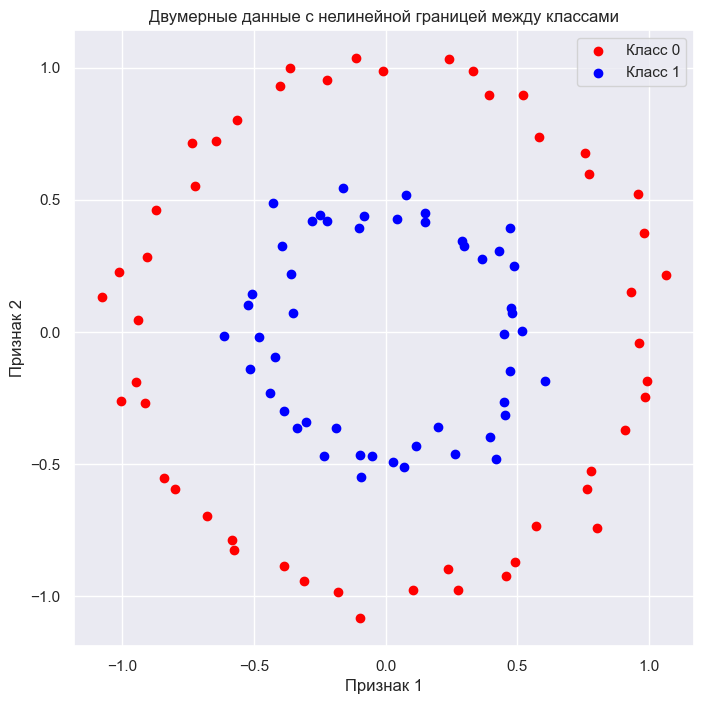

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=100, factor=.5, noise=.05, random_state=42)

plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Класс 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Класс 1')
plt.title('Двумерные данные с нелинейной границей между классами')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()
plt.grid(True)
plt.show()

-------------

Попробуем обучить линейную регрессию c $l_1$ регуляризацией на специальном датасете из sklearn

In [23]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

Взглянем немножко на данные. Выведем средние значения каждого признака

In [24]:
with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print(X_train.mean(axis=0))

[ 3.871  28.668  5.438  1.097  1423.264  3.116  35.621 -119.558]


Нетрудно видеть, что масштаб у разных признаков сильно отличается. Это может приводить к разным неприятным эффектам. Подробнее эту проблему мы разберём в следующем задании.

In [25]:
from sklearn.preprocessing import StandardScaler

### **Вопрос 8** (2 балла)

Отмасштабируйте данные при помощи класса StandardScaler. Выведите средние значения и дисперсии признаков на обучающей и тестовой выборках.

**Замечание:** Результат положите в переменные X_train_scaled и X_test_scaled , чтобы последующий код был рабочим

In [31]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Среднее значение X_train_scaled:", X_train_scaled.mean())
print("Дисперсия X_train_scaled:", X_train_scaled.std())
print("Среднее значение X_test_scaled:", X_test_scaled.mean())
print("Дисперсия X_test_scaled:", X_test_scaled.std())

Среднее значение X_train_scaled: -3.7179561754888965e-16
Дисперсия X_train_scaled: 0.9999999999999989
Среднее значение X_test_scaled: -0.00379663956478136
Дисперсия X_test_scaled: 0.9755767543588673


Измерим качество прогнозатора. Будем использовать метрику RMSE.

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
reg = Lasso(alpha=0.5)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.9780


### **Вопрос 9** (1 балл)

В чем плюсы RMSE по сравнению с MSE?

1. Одним из основных преимуществ RMSE является то, что она находится в тех же единицах измерения, что и целевая переменная 
$y$. Это делает RMSE более интерпретируемой и понятной с точки зрения ошибки прогноза.

2. И RMSE, и MSE накладывают больший штраф на большие ошибки (так как ошибка возводится в квадрат), но поскольку RMSE измеряется в тех же единицах, что и исходные значения, большие ошибки становятся более заметными при использовании RMSE.

3. RMSE усиливает и выделяет большие ошибки (выбросы), что может быть желательным, когда очень большие ошибки нежелательны и должны быть минимизированы.

### **Вопрос 10** (1 балл)

Насколько удачно измерять качество модели с помощью RMSE с учетом того, что оптимизация линейной регрессии происходит по MSE?

Использование RMSE в качестве метрики качества модели, оптимизированной с использованием MSE, является вполне удачным выбором. Несмотря на то что оптимизация линейной регрессии происходит по MSE, RMSE представляет собой лишь квадратный корень из MSE и сохраняет те же свойства, делая обе метрики взаимозаменяемыми в контексте оптимизации.

-----

Проанализируем ошибку на обучающей выборке.

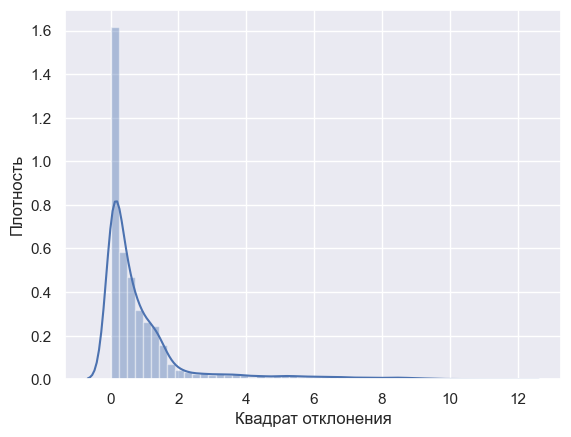

In [34]:
error = (y_train - reg.predict(X_train_scaled)) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Как видно, есть несколько объектов, на которых модель ошибается сильно. Давайте посмотрим на качество, если удалить эти объекты из обучающей выборки.

In [35]:
mask = (error < np.quantile(error, 0.99))
reg.fit(X_train_scaled[mask], y_train[mask])
y_pred = reg.predict(X_test_scaled)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.9717


Таким образом, можно улучшить качество линейной регрессии, если удалить из обучающей выборки выбросы. В данном примере, качество улучшилось не так сильно, но бывают ситуации, когда чистка обучающей выборки по ошибке, приводит к сильному улучшению качества.

Обратим внимание на веса модели. Почти все из них занулились! Это большое преимущество, так как разреживание весов позволяет отбирать нужные признаки, делая модель более лёгкой.

In [36]:
reg.coef_

array([ 0.30658523,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ])

А теперь обучим с $l_2$ регуляризацией.

In [37]:
reg = Ridge(alpha=0.5)
reg.fit(X_train_scaled, y_train)
print(reg.coef_)

[ 0.82540051  0.12701227 -0.24066504  0.27101941 -0.00317096 -0.04117445
 -0.87312407 -0.84556157]


Как видим, веса не разрежены, хотя и есть очень маленькие значения

### **Вопрос 11** (2 балла)

Приведите пример, когда линейная регрессия с $l_2$ регуляризацией гарантированно занулит какой-нибудь признак?

Градиентный спуск будет уменьшать веса, стремясь минимизировать функцию потерь, но квадратичный характер штрафа не приводит к полному занулению весов.

Однако, например, если признак является константным, то при взятии производной функции потерь будет получаться 0. Отсюда получим зануление веса.

------

При обучении мы заранее не знаем, какое значение параметра регуляризации даст наилучшие результаты. Подобрать оптимальные параметры можно с помощью кросс-валидации. В sklearn есть несколько классов со встроенной кросс-валидацией

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Воспользуемся классом GridSearch для перебора параметров по сетке.

* Для линейных регрессий перебирается параметр $\alpha$ - сила регуляризации. Обычно важнее перебирать порядок этого параметра, а не точное его значение. В силу этого сетку перебора будет удобно сделать через функцию np.logspace, например np.logspace(-3, 3, 10).

### Вопрос 12 (2 балла)

Воспользуйтесь классом [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подберите константы регуляризации для Lasso и Ridge регрессий. Измерьте качество обученных моделей. Сетка перебора должна быть логарифмической, из хотя бы 10 значений


**Подсказка:**
* Пример, как можно перебирать параметры в GridSearch у вложенных [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) можно [найти вот тут](https://www.kaggle.com/code/ilnazsalimov/gridsearch-with-pipeline)
* Обратите внимание, что сейчас мы сразу заносим масштабирование в Pipeline - чтобы иметь возможность сразу вызываться от оригинальных X_train, а также чтобы не было утечки данных при использовании GridSearch
* В GridSearch в качестве скоринговой функции можно подавать строковое описание функции из sklearn, которое [можно посмотреть вот тут](https://scikit-learn.org/stable/modules/model_evaluation.html), а также саму скоринговую функцию из sklearn или собственную функцию, сделанную [через make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)

**Замечание:** Итоговое качество должно быть не больше 0.73 RMSE.

In [42]:
model_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Lasso())
])

model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Ridge())
])

alpha_values = np.logspace(-4, 4, 100)

param_grid_lasso = {'regr__alpha': alpha_values}
param_grid_ridge = {'regr__alpha': alpha_values}

lasso_cv = GridSearchCV(
    model_lasso,
    cv=5,
    scoring="neg_root_mean_squared_error",
    param_grid = param_grid_lasso
)

ridge_cv = GridSearchCV(
    model_ridge,
    cv=5,
    scoring="neg_root_mean_squared_error",
    param_grid = param_grid_ridge
)

lasso_cv.fit(X_train_scaled, y_train)
ridge_cv.fit(X_train_scaled, y_train)

lasso_best_rmse = -lasso_cv.best_score_
ridge_best_rmse = -ridge_cv.best_score_

print(f"Лучший RMSE для Lasso: {lasso_best_rmse:.2f}")
print(lasso_cv.best_params_)
print(f"Лучший RMSE для Ridge: {ridge_best_rmse:.2f}")
print(ridge_cv.best_params_)

Лучший RMSE для Lasso: 0.73
{'regr__alpha': 0.004977023564332114}
Лучший RMSE для Ridge: 0.73
{'regr__alpha': 54.62277217684348}


Убедимся, что Lasso всё ещё зануляет признаки (скорее всего модель Lasso занулила хотя бы один).

In [43]:
lasso_cv.best_estimator_.named_steps["regr"].coef_

array([ 0.8006678 ,  0.13061938, -0.17855543,  0.20874856, -0.        ,
       -0.03620985, -0.82054455, -0.78972537])

**Выводы** В первой части задания по линейным моделям мы должны были узнать:
.

1.   Зачем нужна регуляризация.
2.   Как отбирать значащие признаки.
3.   Когда линейные модели работают хорошо, а когда плохо

-----
<font color="white" style="opacity:0.2023"></font>

Во **второй части** мы будем применять линейные модели для классификации реальных данных, где мы сможем проверить наши выводы, полученные на искуственных примерах. А также убедимся в полезности нормировки и научимся работать с разными видами данных.
